# Курсовой проект 'PyTorch framework'

### Постановка задачи

Написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.

In [61]:
# Loading libraries ...

import numpy as np
import pandas as pd

import PIL
from PIL import Image
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid

from facenet_pytorch import MTCNN

**Модель классификации жестов была предобучена отдельно на Google Colab.** Для реализации задания с веб-камерой, вторая часть проекта была перенесена на локальную машину.

In [62]:
# Как выглядела сеть для классификации жестов

def conv_block(in_channels, out_channels, pool=False):
    
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)

# Блок линейных слоев
def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):
    
    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())
        
    return nn.Sequential(*layers)


#  Сеть
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # Конволюционная часть сети
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)

        
        self.max_pool = nn.MaxPool2d(6)
        self.flatten = nn.Flatten()
        
        self.ff1 = linear_block(512, 256, activation = True)
        self.ff2 = linear_block(256, 128, activation = True)
        self.classifier = linear_block(128, num_classes)
        
    def forward(self, xb):
        #Convolution layers
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) 
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.max_pool(out)
        out = self.flatten(out)
        
        # Feed Forward layers
        out = self.ff1(out)
        out = self.ff2(out)
        out = self.classifier(out)
        
        return out

In [63]:
# Дополнительно для решения проблемы с загрузкой модели
gesture_clf = ResNet(1, 10)

In [64]:
# Проверка загрузки модели
gesture_clf = torch.load('./gesture_classification_model_1ver.pth', map_location=torch.device('cpu'))

## Модель детекции лиц MTCNN + Модель классификации жестов

In [150]:
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.gestmodel = torch.load('./gesture_classification_model_1ver.pth', map_location=torch.device('cpu'))
        self.gestmodel.eval()

    # ОТРИСОВКА НА КАДРЕ
    def _draw(self, frame, boxes, landmarks, gesture):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, ld in zip(boxes, landmarks):
                cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), 
                              (255,255,0), thickness=2)

                # Show probability
                cv2.putText(frame, 
                    gesture, (int(box[2]), int(box[3])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

                # Draw landmarks
                cv2.circle(frame, tuple([int(i) for i in ld[0]]), 5, (255,255,0), -1)
                cv2.circle(frame, tuple([int(i) for i in ld[1]]), 5, (255,255,0), -1)
                cv2.circle(frame, tuple([int(i) for i in ld[2]]), 5, (255,255,0), -1)
                cv2.circle(frame, tuple([int(i) for i in ld[3]]), 5, (255,255,0), -1)
                cv2.circle(frame, tuple([int(i) for i in ld[4]]), 5, (255,255,0), -1)
        except:
            pass

        return frame
    
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    # ТРАНСФОРМАЦИЯ КАДРА ДЛЯ МОДЕЛИ КЛАССИФИКАЦИИ ЖЕСТОВ
    @staticmethod
    def transform_frame(frame):
        transformer = transforms.Compose([  
                      transforms.ToPILImage(),
                      transforms.Grayscale(num_output_channels=1),
                      transforms.Resize((48,48)),
                      transforms.ToTensor()]) 
        
        return transformer(frame).unsqueeze(1)
        
    # ПЕРЕВОД ЧИСЛОВЫХ ПРЕДСТАВЛЕНИЙ КЛАССОВ В ТЕКСТОВОЕ
    @staticmethod
    def num_to_classname(num):
        if num == 0:
            return 'palm'
        elif num == 1:
            return 'l'
        elif num == 2:
            return 'fist'
        elif num == 3:
            return 'fist_moved'
        elif num == 4:
            return 'thumb'
        elif num == 5:
            return 'index'
        elif num == 6:
            return 'ok'
        elif num == 7:
            return 'palm_moved'
        elif num == 8:
            return 'c'
        elif num == 9:
            return 'down'

        
    # РЕАКЦИИ НА ЖЕСТЫ
    @staticmethod
    def reactions_to_gestures(gesture):
        if gesture == 'thumb':
            plt.imshow(cv2.cvtColor(cv2.imread('./imgs reactions/good jıb.jpeg'), cv2.COLOR_BGR2RGB))
            plt.show()
            print(f"Hi! See your photo below, you're amazing today :D. Your gesture is {gesture}, am I right?")
            
        elif gesture == 'ok':
            plt.imshow(cv2.cvtColor(cv2.imread('./imgs reactions/ok.jpeg'), cv2.COLOR_BGR2RGB))
            plt.show()
            print(f"Hey, you're showing OK! See your photo below! :D. I think, your gesture is {gesture}, am I right?")
        
        elif gesture == 'palm' or gesture == 'palm_moved':
            plt.imshow(cv2.cvtColor(cv2.imread('./imgs reactions/palm.jpeg'), cv2.COLOR_BGR2RGB))
            plt.show()
            print(f"Hi! See your photo below, you're amazing today :D. Your gesture is {gesture}, am I right?")
            
        elif gesture == 'fist' or  gesture == 'fist_moved':
            print(f"Hey, why you angry today? :( I think, your gesture is {gesture}, am I right?")
            plt.imshow(cv2.cvtColor(cv2.imread('./imgs reactions/fist.jpeg'), cv2.COLOR_BGR2RGB))
            plt.show()
    
        else:
            game(15)
            print(f'Hi! I think, your gesture is {gesture}, am I right?')
              
    
    # ИГРА КАК РЕАКЦИЯ НА ЖЕСТЫ
    @staticmethod
    def game(turns):
        print(f"Let's play the game! Try to guess the word letter by letter!You have {turns} attempts!")
    
        want_to_play= input('Do you want to play? Enter Y or N: ')[0]
        want_to_play.lower()

        if want_to_play == 'y':

            # Список слов, которые участвуют в игре
            wordList = ["python", "pytorch", "nets", "framework"]
            # Перемешиваем список.
            shuffle(wordList)
            # Берем последнее слово из списка.
            word = wordList.pop()

            # Угаданные буквы
            guesses = "" 

            # Цикл, который будет работать, пока не останется попыток или неотгаданных букв.
            while turns > 0:
                wrong = 0

                for letter in word:
                    if letter in guesses:
                        print(letter, end=" ")
                    else:
                        print("_", end=" ")
                        wrong += 1

                print("\n")

                if wrong == 0:
                    print("You win!!! :)")
                    break

                guess = ""
                guess = input("Enter the ENGLISH letter and press 'enter': ")[0]
                guess.lower()
                if guess in guesses:
                    print("You had entered this letter before")
                guesses += guess

                turns -=1
                if guess not in word:
                    print(f"No letter {guess} in this word ")

                else:
                    print(f"Correct! Letter {guess} contains in our word ")


                print(f"You have {turns} attempts left")


                if turns == 0:
                    print("Sorry, you lose :(")

        if want_to_play == 'n': 
            print('See you next time! Bye;)')
                
                  
    # ЗАПУСК ПРОГРАММЫ
    def run(self):
        
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        try:
            cap = cv2.VideoCapture(0) # фиксация изображений с экрана с помощью веб камеры (0- 1я камера)
#             Меняет уровень осветления 
            for i in range(3):
                cap.read()
            ret, frame = cap.read()
            
            # Работа с кадром
            boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)

            face = self.crop_faces(frame, boxes)[0]

            frame_for_model = self.transform_frame(frame)
            gesture = self.gestmodel(frame_for_model)
            gesture = self.num_to_classname(gesture.argmax())
            self.reactions_to_gestures(gesture)

            # draw on frame
            self._draw(frame, boxes, landmarks, gesture)
            
            # Show the frame
            plt.imshow(frame)
            plt.show()

            
        except:
            pass
    
        cap.release()
        cv2.destroyAllWindows()

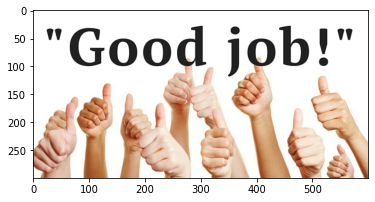

Hi! See your photo below, you're amazing today :D. Your gesture is thumb, am I right?


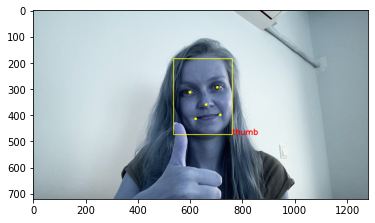

In [69]:
# FIRST run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)
fcd.run()

In [78]:
# SECOND run the app
fcd = FaceDetector(mtcnn)
fcd.run()

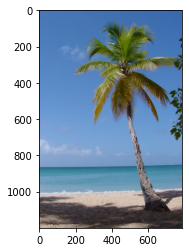

Hi! See your photo below, you're amazing today :D. Your gesture is palm, am I right?


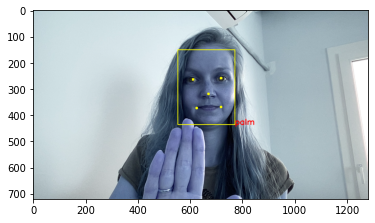

In [35]:
# THIRD run the app
fcd = FaceDetector(mtcnn)
fcd.run()

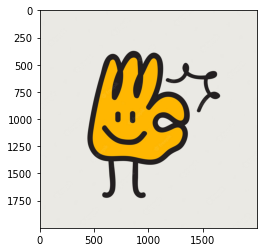

Hey, you're showing OK! See your photo below! :D. I think, your gesture is ok, am I right?


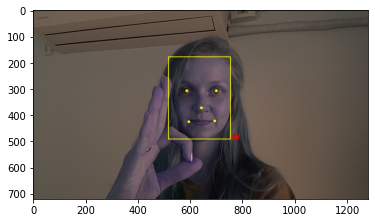

In [84]:
# THIRD run the app
fcd = FaceDetector(mtcnn)
fcd.run()

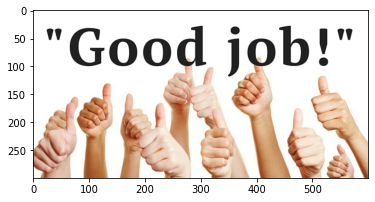

Hi! See your photo below, you're amazing today :D. Your gesture is thumb, am I right?


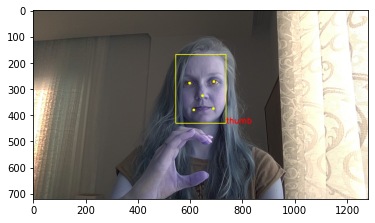

In [110]:
# FOURTH run the app
fcd = FaceDetector(mtcnn)
fcd.run()

Неверно классифицирован

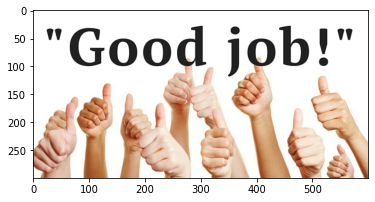

Hi! See your photo below, you're amazing today :D. Your gesture is thumb, am I right?


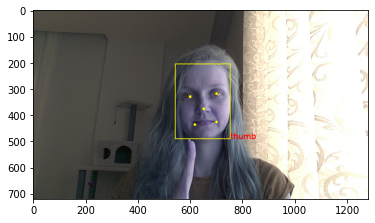

In [137]:
# FIFTH run the app
fcd = FaceDetector(mtcnn)
fcd.run()

Неверно классифицирован

In [107]:
# cap.release()

**Вывод:** Модель показывает хорошие результаты на валидационных данных, но на тестовых некоторые жесты классифицирует некорректно, несмотря на то, что в процессе обучения loss сократился до минимума, а accuracy достигла довольно хорошего уровня. Например, жест 'C' неверно классифицируется, проведено много экспериментов с разным освещением.
Обратила внимание, что при разном уровне яркости (осветления) кадра классификация отдельных жестов улучшается, других ухудшается